## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.7]
redice_lr_patient = [5,7]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 5s 110us/step - loss: 1.4289 - accuracy: 0.5011 - val_loss: 1.5685 - val_accuracy: 0.4482
Epoch 11/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4050 - accuracy: 0.5111 - val_loss: 1.5503 - val_accuracy: 0.4535
Epoch 12/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.3818 - accuracy: 0.5202 - val_loss: 1.5382 - val_accuracy: 0.4595
Epoch 13/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.3608 - accuracy: 0.5287 - val_loss: 1.5273 - val_accuracy: 0.4617
Epoch 14/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.3406 - accuracy: 0.5346 - val_loss: 1.5244 - val_accuracy: 0.4607
Epoch 15/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.3205 - accuracy: 0.5421 - val_loss: 1.5212 - val_accuracy: 0.4645
Epoch 16/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3025 - accuracy: 0.5496 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 119us/step - loss: 2.3297 - accuracy: 0.2383 - val_loss: 2.1731 - val_accuracy: 0.1787
Epoch 2/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.8531 - accuracy: 0.3601 - val_loss: 2.0174 - val_accuracy: 0.2805
Epoch 3/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.7231 - accuracy: 0.3975 - val_loss: 1.8884 - val_accuracy: 0.3378
Epoch 4/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.6487 - accuracy: 0.4230 - val_loss: 1.7887 - val_accuracy: 0.3684
Epoch 5/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.5958 - accuracy: 0.4423 - val_loss: 1.7101 - val_accuracy: 0.3975
Epoch 6/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.5527 - accuracy: 0.4580 - val_loss: 1.6556 - val_accuracy: 0.4199
Epoch 7/25
50000/50000 [==============================] - 5s 1

50000/50000 [==============================] - 6s 124us/step - loss: 0.5753 - accuracy: 0.8173 - val_loss: 1.4931 - val_accuracy: 0.5110
Epoch 20/25
50000/50000 [==============================] - 7s 146us/step - loss: 0.5513 - accuracy: 0.8273 - val_loss: 1.5133 - val_accuracy: 0.5072
Epoch 21/25
50000/50000 [==============================] - 7s 143us/step - loss: 0.5278 - accuracy: 0.8356 - val_loss: 1.5194 - val_accuracy: 0.5106
Epoch 22/25
50000/50000 [==============================] - 7s 131us/step - loss: 0.5038 - accuracy: 0.8450 - val_loss: 1.6192 - val_accuracy: 0.5110

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 23/25
50000/50000 [==============================] - 6s 125us/step - loss: 0.4561 - accuracy: 0.8667 - val_loss: 1.5273 - val_accuracy: 0.5206
Epoch 24/25
50000/50000 [==============================] - 6s 122us/step - loss: 0.4348 - accuracy: 0.8758 - val_loss: 1.5256 - val_accuracy: 0.5186
Epoch 25/25
50000/50000 [============

50000/50000 [==============================] - 6s 120us/step - loss: 1.5389 - accuracy: 0.4620 - val_loss: 1.8261 - val_accuracy: 0.3770
Epoch 3/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.4391 - accuracy: 0.4977 - val_loss: 1.6904 - val_accuracy: 0.4174
Epoch 4/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.3681 - accuracy: 0.5263 - val_loss: 1.5929 - val_accuracy: 0.4542
Epoch 5/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.3124 - accuracy: 0.5457 - val_loss: 1.5289 - val_accuracy: 0.4714
Epoch 6/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.2624 - accuracy: 0.5625 - val_loss: 1.5381 - val_accuracy: 0.4545
Epoch 7/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.2222 - accuracy: 0.5779 - val_loss: 1.4830 - val_accuracy: 0.4769
Epoch 8/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.1859 - accuracy: 0.5904 - val_loss: 1.488

Epoch 21/25
50000/50000 [==============================] - 6s 115us/step - loss: 0.9927 - accuracy: 0.6698 - val_loss: 1.4600 - val_accuracy: 0.4928
Epoch 22/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.9779 - accuracy: 0.6780 - val_loss: 1.4407 - val_accuracy: 0.4988
Epoch 23/25
50000/50000 [==============================] - 6s 129us/step - loss: 0.9638 - accuracy: 0.6807 - val_loss: 1.4507 - val_accuracy: 0.4986
Epoch 24/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.9476 - accuracy: 0.6905 - val_loss: 1.4401 - val_accuracy: 0.5048
Epoch 25/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.9335 - accuracy: 0.6958 - val_loss: 1.4418 - val_accuracy: 0.5011
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)       

50000/50000 [==============================] - 7s 131us/step - loss: 1.2748 - accuracy: 0.5526 - val_loss: 1.7799 - val_accuracy: 0.3769
Epoch 6/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.2231 - accuracy: 0.5711 - val_loss: 1.8821 - val_accuracy: 0.3647
Epoch 7/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.1742 - accuracy: 0.5882 - val_loss: 1.8791 - val_accuracy: 0.3815
Epoch 8/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.1268 - accuracy: 0.6071 - val_loss: 1.6959 - val_accuracy: 0.4078
Epoch 9/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.0872 - accuracy: 0.6225 - val_loss: 1.7905 - val_accuracy: 0.3800
Epoch 10/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.0565 - accuracy: 0.6317 - val_loss: 2.0558 - val_accuracy: 0.3580
Epoch 11/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.0163 - accuracy: 0.6473 - val_loss: 1.6

50000/50000 [==============================] - 7s 134us/step - loss: 0.6334 - accuracy: 0.8006 - val_loss: 1.5819 - val_accuracy: 0.4874
Epoch 24/25
50000/50000 [==============================] - 6s 129us/step - loss: 0.6140 - accuracy: 0.8077 - val_loss: 1.5299 - val_accuracy: 0.5037
Epoch 25/25
50000/50000 [==============================] - 6s 126us/step - loss: 0.5963 - accuracy: 0.8161 - val_loss: 1.5336 - val_accuracy: 0.5029
Numbers of exp: 11, reduce_factor: 0.70, reduce_patient: 7
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
__________________________

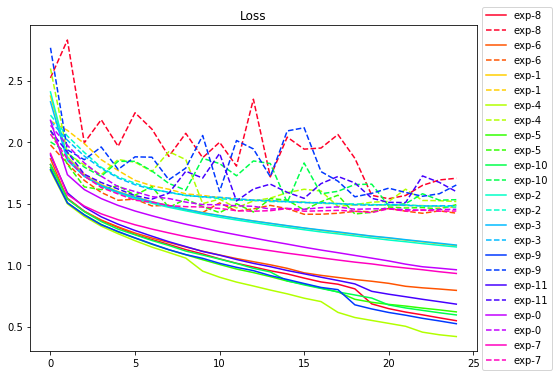

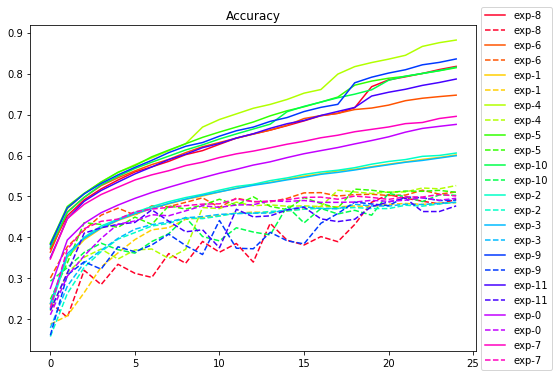

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()